In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

# import lightgbm as lgb

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, Dot
from keras import regularizers
# from keras.losses import mse, binary_crossentropy

# 데이터 불러오기

In [22]:
ratingDF = pd.read_csv("philadelphia_reviews.csv")
ratingDF = ratingDF.drop_duplicates(["user_id", "business_id"])
ratingDF

,user_id,business_id,stars
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5
1,kSMOJwJXuEUqzfmuFncK4A,kxX2SOes4o-D3ZQBkiMRfA,2
2,mqBWACmaHflW4eh_Ofp16Q,kxX2SOes4o-D3ZQBkiMRfA,5
3,Z-xgVb4nM42943m2wbBkFw,kxX2SOes4o-D3ZQBkiMRfA,5
4,2SEoXb6r6hPKrl9V9VzBgA,kxX2SOes4o-D3ZQBkiMRfA,5
...,...,...,...
738683,reFwg-F-MCoRS1pA2YexMg,BEuGzy5gxtGyOEk8iwDfTg,5
738684,dh3UhfqpFSoCitl8WCrdfw,BEuGzy5gxtGyOEk8iwDfTg,5
738685,nXwPLYvazD_Nd2Sar3eSWA,BEuGzy5gxtGyOEk8iwDfTg,5
738686,MlOJCxiiB1TeZN-is2Q4SA,BEuGzy5gxtGyOEk8iwDfTg,5


## 데이터 집계

In [23]:
n_users = ratingDF.user_id.unique().shape[0]
n_businesses = ratingDF.business_id.unique().shape[0]
n_ratings = len(ratingDF)
aver_ratings_per_user = n_ratings/n_users

print("Num of users:", n_users)
print("Num of businesses:", n_businesses)
print("Num of ratings:", n_ratings)
print("Average of ratings per user:", aver_ratings_per_user)

Num of users: 216944
Num of businesses: 7076
Num of ratings: 715637
Average of ratings per user: 3.2987176414189836


# 인덱스 정수형 변환

## User ID 생성

In [24]:
users = ratingDF.user_id.unique()
userDF = pd.DataFrame(data=users, columns=["originalUserId"])
userDF["newUserId"] = userDF.index + 1
userDF

,originalUserId,newUserId
0,_7bHUi9Uuf5__HHc_Q8guQ,1
1,kSMOJwJXuEUqzfmuFncK4A,2
2,mqBWACmaHflW4eh_Ofp16Q,3
3,Z-xgVb4nM42943m2wbBkFw,4
4,2SEoXb6r6hPKrl9V9VzBgA,5
...,...,...
216939,HzsMA4M0wwJtYpIuy-TKig,216940
216940,xbX64Rq2_xCb4WRO3aYG-g,216941
216941,4rYuARoWNIYSfVyG6zNrmA,216942
216942,WLaCTpXXdrFKlUTXDsp6Tg,216943


## Business ID 생성

In [25]:
businesses = ratingDF.business_id.unique()
businessDF = pd.DataFrame(data=businesses, columns=["originalBusinessId"])
businessDF["newBusinessId"] = businessDF.index + 1
businessDF

,originalBusinessId,newBusinessId
0,kxX2SOes4o-D3ZQBkiMRfA,1
1,04UD14gamNjLY0IDYVhHJg,2
2,RZtGWDLCAtuipwaZ-UfjmQ,3
3,YtSqYv1Q_pOltsVPSx54SA,4
4,eFvzHawVJofxSnD7TgbZtg,5
...,...,...
7071,ruPaJWpkFnyBxsN_LnnmQw,7072
7072,7gNY2fx_8-RFicmecY3RsA,7073
7073,suu00nBOfDsTOjSm_WtV8A,7074
7074,K1SsvIPfFcHniNSPc3IG7g,7075


## 정수 인덱스 추가

In [26]:
ratingDF = ratingDF.merge(userDF, left_on="user_id", right_on="originalUserId")
ratingDF.drop(labels="originalUserId", axis=1, inplace=True)

ratingDF = ratingDF.merge(businessDF, left_on="business_id", right_on="originalBusinessId")
ratingDF.drop(labels="originalBusinessId", axis=1, inplace=True)

ratingDF

,user_id,business_id,stars,newUserId,newBusinessId
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,1
1,kSMOJwJXuEUqzfmuFncK4A,kxX2SOes4o-D3ZQBkiMRfA,2,2,1
2,mqBWACmaHflW4eh_Ofp16Q,kxX2SOes4o-D3ZQBkiMRfA,5,3,1
3,Z-xgVb4nM42943m2wbBkFw,kxX2SOes4o-D3ZQBkiMRfA,5,4,1
4,2SEoXb6r6hPKrl9V9VzBgA,kxX2SOes4o-D3ZQBkiMRfA,5,5,1
...,...,...,...,...,...
715632,BByOqQ8d_pKDH8pz4QvWWA,AuOBDegADgRWYDVpfgsgfw,1,202065,6228
715633,P1L-wYUTpvLEDq9D2TOexQ,AuOBDegADgRWYDVpfgsgfw,1,202066,6228
715634,GRAOH8iUq9B8MtZVjRZl_Q,AuOBDegADgRWYDVpfgsgfw,5,202067,6228
715635,o3UaM3DbI5dbERHYHD9Njw,AuOBDegADgRWYDVpfgsgfw,1,202068,6228


# 데이터 세트 분리

In [27]:
X_train, X_test = train_test_split(ratingDF, test_size=0.40, shuffle=True)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True)

In [28]:
print("Size of train set:", X_train.shape[0])
print("Size of validation set:", X_validation.shape[0])
print("Size of test set:", X_test.shape[0])

Size of train set: 429382
Size of validation set: 143127
Size of test set: 143128


# 행렬 생성

## 훈련 세트의 평점 행렬 생성

In [29]:
ratings_train = np.zeros((n_users, n_businesses))
for row in X_train.itertuples():
    ratings_train[row[4] - 1, row[5] - 1] = row[3]

## 검증 세트의 평점 행렬 생성

In [30]:
ratings_validation = np.zeros((n_users, n_businesses))
for row in X_validation.itertuples():
    ratings_validation[row[4] - 1, row[5] - 1] = row[3]

## 테스트 세트의 평점 행렬 생성

In [31]:
ratings_test = np.zeros((n_users, n_businesses))
for row in X_test.itertuples():
    ratings_test[row[4] - 1, row[5] - 1] = row[3]

# 훈련

In [48]:
n_latent_factors = 1

user_input = Input(shape=[1], name="user")
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name="user_embedding")(user_input)
user_vec=Flatten(name="flatten_usrs")(user_embedding)

business_input = Input(shape=[1], name="business")
business_embedding = Embedding(input_dim=n_businesses + 1, output_dim=n_latent_factors, name="business_embedding")(business_input)
business_vec=Flatten(name="flatten_businesses")(business_embedding)

product = Dot(axes=1)([business_vec, user_vec])
model = Model(inputs=[user_input, business_input], outputs=product)
model.compile("adam", "mean_squared_error")

In [55]:
history = model.fit(x=[X_train.newUserId, X_train.newBusinessId],
                    y=X_train.stars,
                    epochs=100,
                    validation_data=([X_validation.newUserId, X_validation.newBusinessId], X_validation.stars),
                    verbose=1)

Epoch 1/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 948us/step - loss: 4.5602 - val_loss: 6.5053
Epoch 2/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 1000us/step - loss: 3.9436 - val_loss: 6.2027
Epoch 3/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 975us/step - loss: 3.4140 - val_loss: 5.9668
Epoch 4/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 958us/step - loss: 2.9733 - val_loss: 5.7819
Epoch 5/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 954us/step - loss: 2.6235 - val_loss: 5.6369
Epoch 6/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 958us/step - loss: 2.3178 - val_loss: 5.5209
Epoch 7/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 963us/step - loss: 2.0638 - val_loss: 5.4253
Epoch 8/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 962us/step - loss: 1.8400 - val_loss: 5.3472
Epoch 9/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 961us/step - loss: 1.6657 - val_loss: 5.2820
Epoch 10/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 944us/step - loss: 1.4926 - val_loss: 5.2289
Epoch 11/100
13419/13419 ━━━━━━━━━━━━━━━━━━━━ 13s 949us/st

AttributeError: 'list' object has no attribute 'plot'

Min MSE: 5.077897548675537


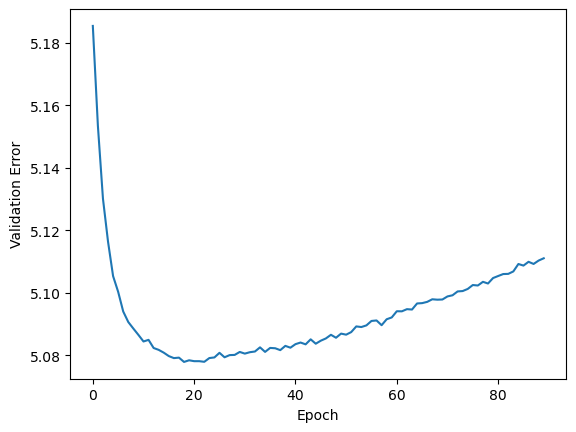

In [58]:
pd.Series(history.history["val_loss"][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print("Min MSE:", min(history.history["val_loss"]))